In [2]:
import pandas as pd
import matplotlib.pyplot as plt



energy_usage = pd.read_csv("archive/EVChargingStationUsage.csv", parse_dates=["Start Date"])
ev_sales = pd.read_csv("archive/vehicle_sales.csv")
weather = pd.read_csv("archive/weather_data.csv")
# Create 'month' column from 'Start Date'
energy_usage['month'] = energy_usage['Start Date'].dt.to_period('M').dt.to_timestamp()

# Aggregate multiple useful metrics
monthly_energy = energy_usage.groupby('month').agg({
    'Energy (kWh)': 'sum',
    'Charging Time (hh:mm:ss)': lambda x: pd.to_timedelta(x).sum().total_seconds() / 3600,  # in hours
    'GHG Savings (kg)': 'sum',
    'Gasoline Savings (gallons)': 'sum',
    'Fee': 'sum',
    'MAC Address': 'count'  # session count
}).reset_index()

# Rename columns
monthly_energy.columns = ['month', 'total_energy_kwh', 'total_charging_time_hrs',
                          'total_ghg_savings_kg', 'total_gasoline_savings_gal',
                          'total_fee_usd', 'charging_sessions']

# Calculate additional metrics
monthly_energy['avg_energy_per_session'] = monthly_energy['total_energy_kwh'] / monthly_energy['charging_sessions']
monthly_energy['avg_charging_time'] = monthly_energy['total_charging_time_hrs'] / monthly_energy['charging_sessions']
monthly_energy['month_num'] = monthly_energy['month'].dt.month

# Check result
print(monthly_energy.head())


C:\Users\vinso\AppData\Local\Temp\ipykernel_25140\2249273349.py:6: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  energy_usage = pd.read_csv("archive/EVChargingStationUsage.csv", parse_dates=["Start Date"])


       month  total_energy_kwh  total_charging_time_hrs  total_ghg_savings_kg  \
0 2011-07-01         72.437273                21.318611                30.424   
1 2011-08-01        781.309083               242.521389               328.148   
2 2011-09-01       1251.386747               375.713611               525.584   
3 2011-10-01       1934.620528               557.986389               812.537   
4 2011-11-01       2084.733485               620.241944               875.595   

   total_gasoline_savings_gal  total_fee_usd  charging_sessions  \
0                       9.091            0.0                  9   
1                      98.054            0.0                137   
2                     157.049            0.0                178   
3                     242.800            0.0                294   
4                     261.633            0.0                311   

   avg_energy_per_session  avg_charging_time  month_num  
0                8.048586           2.368735        

In [3]:
weather.rename(columns={"time": "date"}, inplace=True)
# Convert date column to datetime
weather['date'] = pd.to_datetime(weather['date'])

# Create 'month' column (first day of the month)
weather['month'] = weather['date'].dt.to_period('M').dt.to_timestamp()

weather_monthly = weather.groupby('month').agg({
    'temperature_2m_min': 'mean',
    'precipitation_sum': 'sum'
}).reset_index()

print(weather_monthly.head())

       month  temperature_2m_min  precipitation_sum
0 2020-01-01            7.380645                7.9
1 2020-02-01            8.920690                6.7
2 2020-03-01            9.306452              140.8
3 2020-04-01           11.680000               93.8
4 2020-05-01           14.067742                5.3


In [4]:
# Sort by month first
monthly_energy = monthly_energy.sort_values('month')

# Lag of energy usage (previous month)
monthly_energy['lag_1_energy'] = monthly_energy['total_energy_kwh'].shift(1)

# 3-month rolling average of energy usage
monthly_energy['rolling_avg_3'] = monthly_energy['total_energy_kwh'].rolling(3).mean()

# Drop rows with NaNs (due to lag and rolling)
monthly_energy = monthly_energy.dropna().reset_index(drop=True)


In [5]:
import numpy as np
monthly_energy['target_log'] = np.log1p(monthly_energy['total_energy_kwh'])

In [6]:
# Ensure 'month' is in datetime format
monthly_energy['month'] = pd.to_datetime(monthly_energy['month'])
weather_monthly['month'] = pd.to_datetime(weather_monthly['month'])

# Merge both DataFrames
energy_weather = pd.merge(
    monthly_energy,
    weather_monthly,
    on='month',
    how='inner'  # use 'left' if energy is the main source and some weather values may be missing
)

print(energy_weather.head())

       month  total_energy_kwh  total_charging_time_hrs  total_ghg_savings_kg  \
0 2020-01-01         43172.791              9066.394167             18132.551   
1 2020-02-01         39321.822              8218.897778             16515.191   
2 2020-03-01         19470.564              4050.352222              8177.621   
3 2020-04-01          4860.954               985.468333              2041.610   
4 2020-05-01          6942.764              1409.093056              2915.969   

   total_gasoline_savings_gal  total_fee_usd  charging_sessions  \
0                    5418.174       10883.16               4454   
1                    4934.888        9830.91               4089   
2                    2443.554        4880.93               2001   
3                     610.062        1236.49                487   
4                     871.305        1778.25                688   

   avg_energy_per_session  avg_charging_time  month_num  lag_1_energy  \
0                9.693038           2

In [7]:
# Copy your merged DataFrame
df = energy_weather.copy()

# Sort chronologically
df = df.sort_values('month')
df = df.dropna().reset_index(drop=True)


In [8]:
# Define feature columns
features = [
    'month_num',
    'temperature_2m_min',
    'precipitation_sum',
    'total_fee_usd',
    'total_charging_time_hrs',
    'charging_sessions',
    'rolling_avg_3',
    'lag_1_energy'
]

# Define X and y
X = df[features]
y = df['total_energy_kwh']


In [9]:
# 80% train, 20% test
split = int(len(df) * 0.8)

X_train = X.iloc[:split]
X_test = X.iloc[split:]
y_train = y.iloc[:split]
y_test = y.iloc[split:]


In [10]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize and train model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📉 RMSE: {rmse:.2f}")
print(f"📈 R² Score: {r2:.2f}")


📉 RMSE: 1803.76
📈 R² Score: -0.09


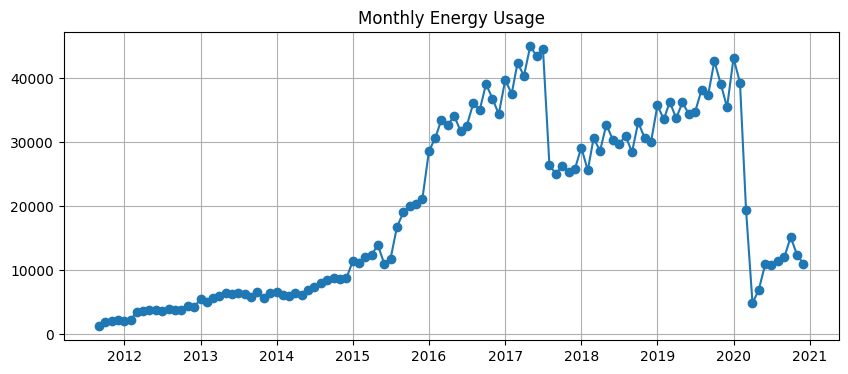

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(monthly_energy['month'], monthly_energy['total_energy_kwh'], marker='o')
plt.title("Monthly Energy Usage")
plt.grid(True)
plt.show()


In [12]:
print(monthly_energy[[
    'total_energy_kwh',
    'lag_1_energy',
    'rolling_avg_3',
    'charging_sessions',
    'avg_energy_per_session',
]].corr())


                        total_energy_kwh  lag_1_energy  rolling_avg_3  \
total_energy_kwh                1.000000      0.964094       0.978654   
lag_1_energy                    0.964094      1.000000       0.992627   
rolling_avg_3                   0.978654      0.992627       1.000000   
charging_sessions               0.994623      0.959540       0.973827   
avg_energy_per_session          0.652216      0.658501       0.672801   

                        charging_sessions  avg_energy_per_session  
total_energy_kwh                 0.994623                0.652216  
lag_1_energy                     0.959540                0.658501  
rolling_avg_3                    0.973827                0.672801  
charging_sessions                1.000000                0.597474  
avg_energy_per_session           0.597474                1.000000  


18:38:05 - cmdstanpy - INFO - Chain [1] start processing
18:38:05 - cmdstanpy - INFO - Chain [1] done processing


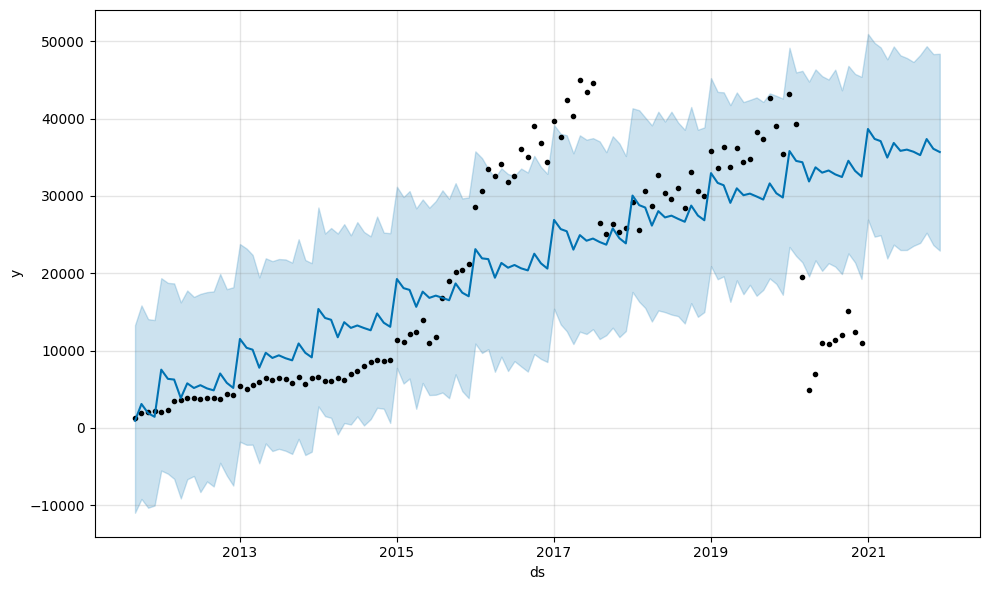

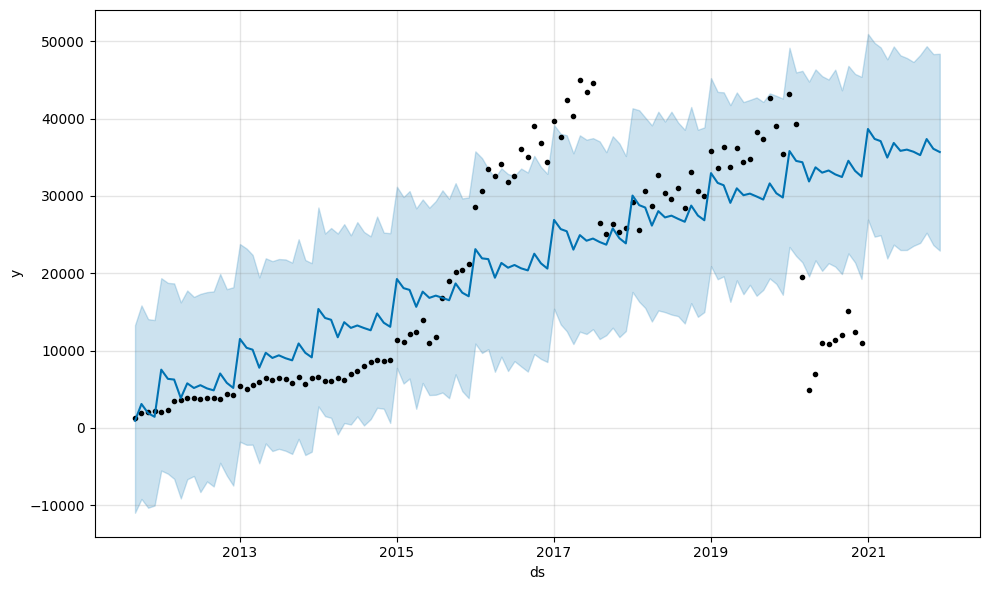

In [18]:
from prophet import Prophet

# Prepare data
df_prophet = monthly_energy[['month', 'total_energy_kwh']].rename(columns={
    'month': 'ds',
    'total_energy_kwh': 'y'
})

# Model
model = Prophet()
model.fit(df_prophet)

# Future dataframe
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# Plot
model.plot(forecast)



In [16]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(df_prophet)


18:37:53 - cmdstanpy - INFO - Chain [1] start processing
18:37:53 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Merge actuals back with forecast
df_merge = df_prophet.merge(forecast[['ds', 'yhat']], on='ds')
rmse = np.sqrt(mean_squared_error(df_merge['y'], df_merge['yhat']))
r2 = r2_score(df_merge['y'], df_merge['yhat'])

print(f"📉 RMSE: {rmse:.2f}")
print(f"📈 R² Score: {r2:.2f}")


📉 RMSE: 9715.16
📈 R² Score: 0.51


19:34:33 - cmdstanpy - INFO - Chain [1] start processing
19:34:33 - cmdstanpy - INFO - Chain [1] done processing


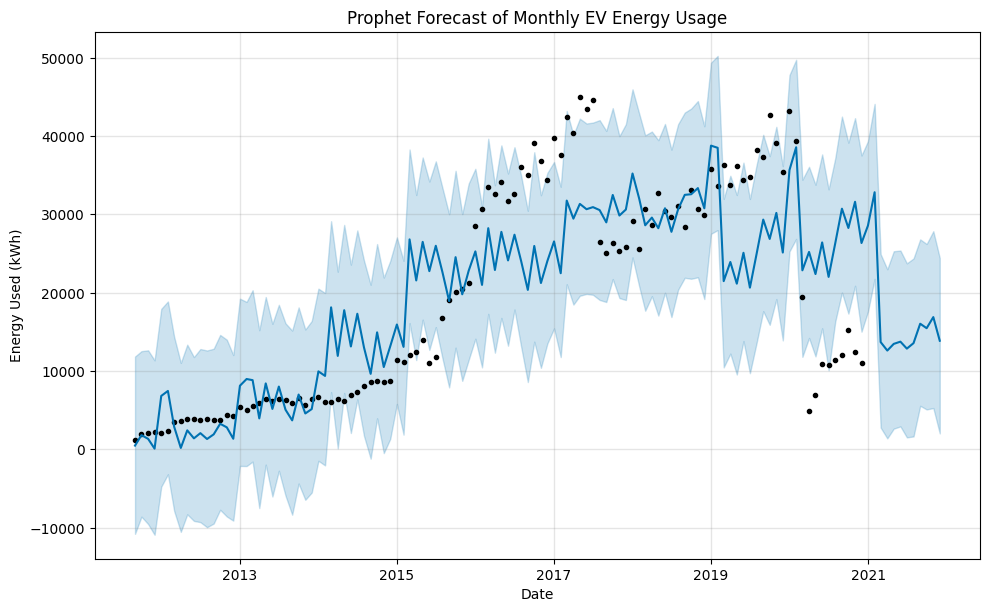

📉 RMSE: 8566.07
📈 R² Score: 0.62


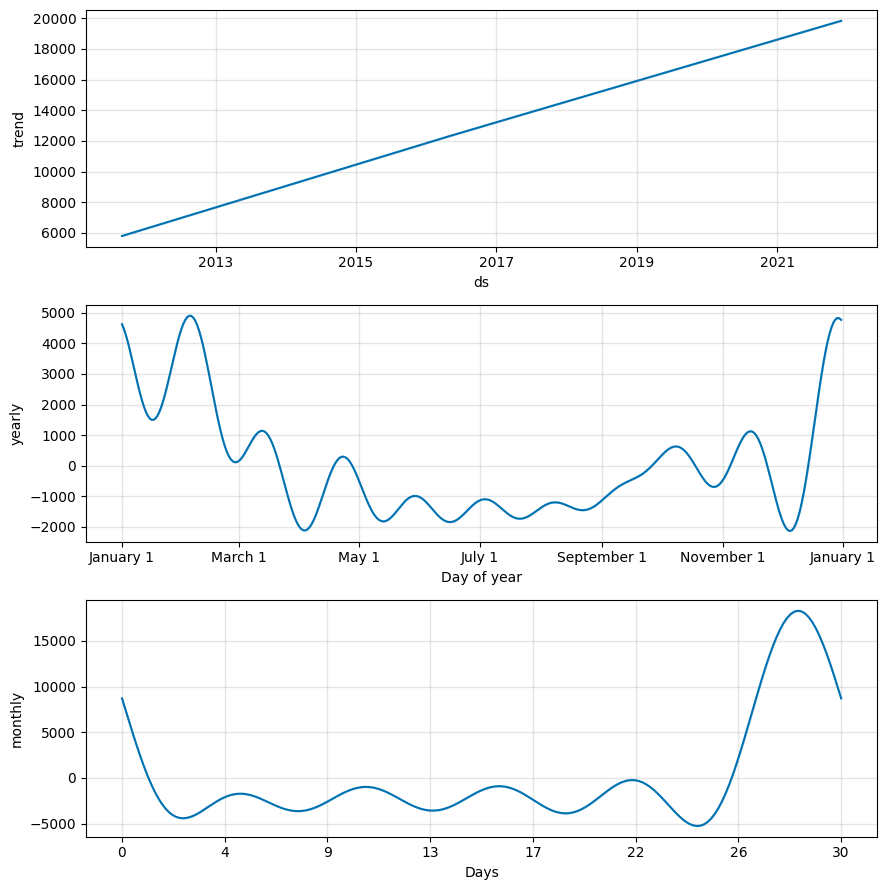

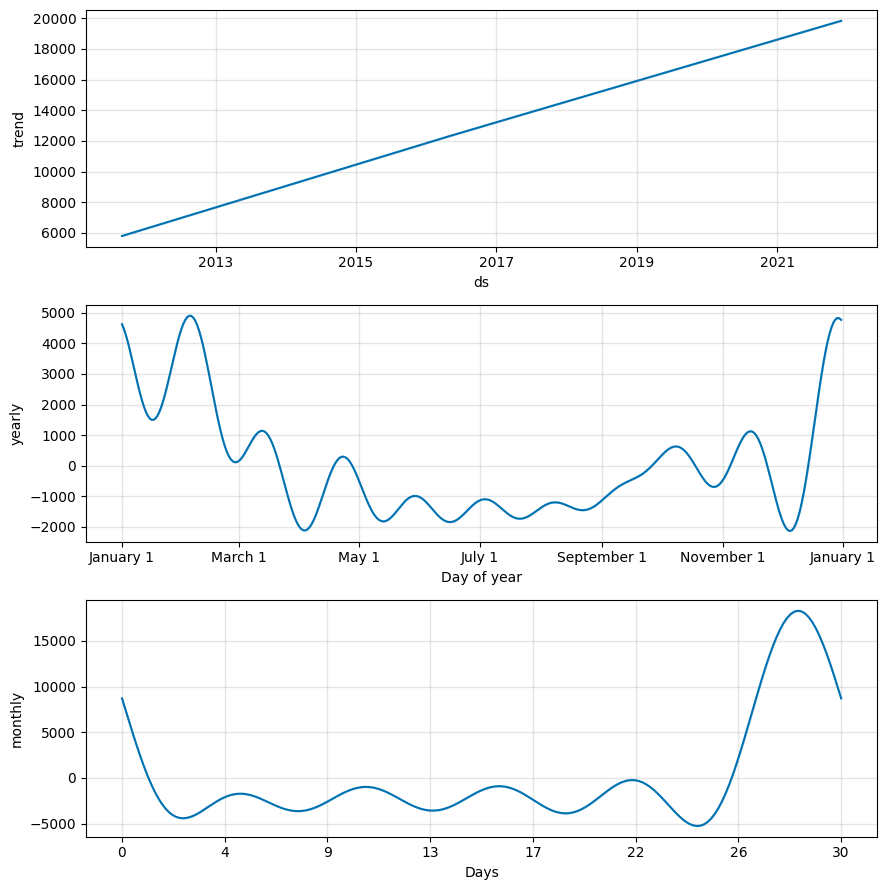

In [26]:
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# STEP 1: Prepare data
df_prophet = monthly_energy[['month', 'total_energy_kwh']].rename(columns={
    'month': 'ds',
    'total_energy_kwh': 'y'
})

# STEP 2: Create model with improved seasonality
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# STEP 3: Fit model
model.fit(df_prophet)

# STEP 4: Create future dataframe
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# STEP 5: Plot forecast
fig1 = model.plot(forecast)
plt.title('Prophet Forecast of Monthly EV Energy Usage')
plt.xlabel('Date')
plt.ylabel('Energy Used (kWh)')
plt.show()

# STEP 6: Evaluate performance
# Merge actuals with predictions
df_eval = df_prophet.merge(forecast[['ds', 'yhat']], on='ds')
rmse = np.sqrt(mean_squared_error(df_eval['y'], df_eval['yhat']))
r2 = r2_score(df_eval['y'], df_eval['yhat'])

print(f"📉 RMSE: {rmse:.2f}")
print(f"📈 R² Score: {r2:.2f}")

# STEP 7 (Optional): Plot seasonality components
model.plot_components(forecast)


20:16:57 - cmdstanpy - INFO - Chain [1] start processing
20:16:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\vinso\AppData\Local\Temp\ipykernel_25140\1793219382.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


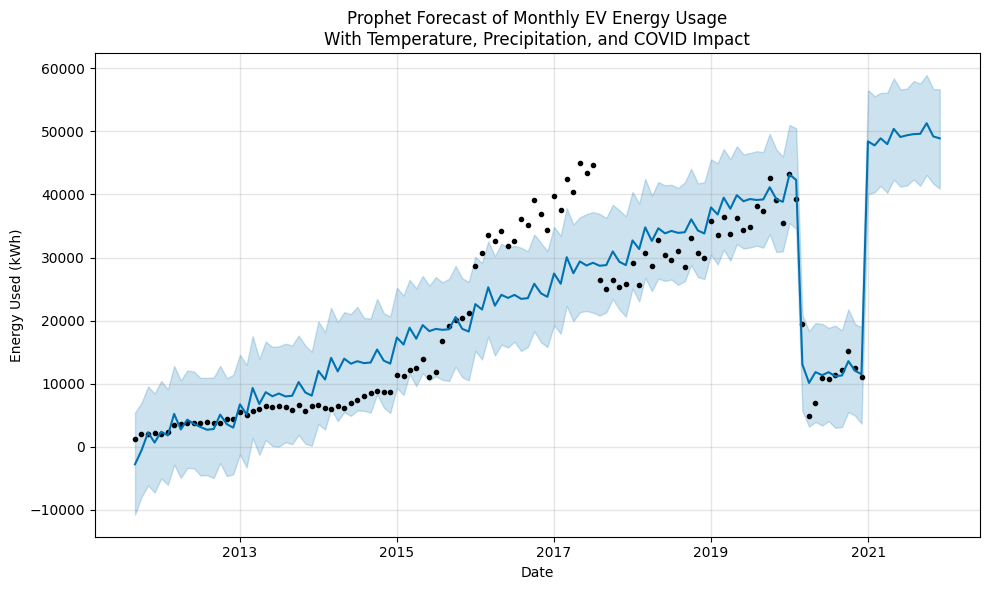

In [34]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Step 1: Prepare your data
df_prophet = monthly_energy[['month', 'total_energy_kwh']].rename(columns={
    'month': 'ds',
    'total_energy_kwh': 'y'
})

# Add weather columns (make sure these are merged already)
df_prophet['temperature'] = energy_weather['temperature_2m_min']  # replace with your actual column
df_prophet['precipitation'] = energy_weather['precipitation_sum']  # replace with your actual column
# Handle missing values in regressors
df_prophet['temperature'] = df_prophet['temperature'].fillna(method='ffill').fillna(method='bfill')
df_prophet['precipitation'] = df_prophet['precipitation'].fillna(method='ffill').fillna(method='bfill')
# Step 2: Add external events (COVID, for example)
covid_impact = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.date_range(start='2020-03-01', end='2020-12-01', freq='MS'),
    'lower_window': 0,
    'upper_window': 0,
})

# Step 3: Build the Prophet model
model = Prophet(yearly_seasonality=True, holidays=covid_impact)
model.add_regressor('temperature')
model.add_regressor('precipitation')

# Step 4: Fit the model
model.fit(df_prophet)

# Create the future DataFrame
future = model.make_future_dataframe(periods=12, freq='M')

# Extend regressor values for future dates using last known values
last_temp = df_prophet['temperature'].iloc[-1]
last_precip = df_prophet['precipitation'].iloc[-1]

# Assign historical values
future = future.merge(df_prophet[['ds', 'temperature', 'precipitation']], on='ds', how='left')

# Fill future rows with last known values
future['temperature'].fillna(last_temp, inplace=True)
future['precipitation'].fillna(last_precip, inplace=True)


# Step 6: Forecast
forecast = model.predict(future)

# Step 7: Plot
fig = model.plot(forecast)
plt.title("Prophet Forecast of Monthly EV Energy Usage\nWith Temperature, Precipitation, and COVID Impact")
plt.xlabel("Date")
plt.ylabel("Energy Used (kWh)")
plt.tight_layout()
plt.show()


In [35]:
forecast = model.predict(future)


In [36]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Merge actuals with forecast
df_eval = pd.merge(df_prophet[['ds', 'y']], forecast[['ds', 'yhat']], on='ds')

# Drop NaNs in case of missing yhat values
df_eval.dropna(inplace=True)

# Calculate RMSE and R²
rmse = np.sqrt(mean_squared_error(df_eval['y'], df_eval['yhat']))
r2 = r2_score(df_eval['y'], df_eval['yhat'])

print(f"📉 RMSE: {rmse:.2f}")
print(f"📈 R² Score: {r2:.2f}")


📉 RMSE: 5858.29
📈 R² Score: 0.82
